# Notebook for exercise 2

## 0. Get data ready

### 0.1 Create X_train, X_test, y_train, test 

This is the same procedure that i did in the previous tasks too.

In [15]:
# Import the necessary libraries
import os   #helps me erase a warning that i am getting
import numpy as np  #the data are numpy when i first get them
from sklearn.preprocessing import StandardScaler  #need this for standardizing the data
from sklearn.decomposition import PCA #need this for the PCA in the data
import torch
from torch import nn #need this for my model (layers, loss functions, ...)
from sklearn.metrics import accuracy_score #need this to measure the accuracy of the model
import time  #need this to calcualate the training time
from pathlib import Path #need this for the save_model(). 
import matplotlib.pyplot as plt  # need this for the model's plots
import pandas as pd 
from sklearn.svm import SVC #need this for the SVM model
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV #need this for the GridSearchCV model which is used to find the best hyperparameters

from sklearn.multiclass import OneVsRestClassifier #need this for the OneVsRestClassifier model, which is used to make the SVM model multiclass
from sklearn.metrics.pairwise import euclidean_distances 
from sklearn.model_selection import RandomizedSearchCV #need this for the RandomizedSearchCV model which is used to find the best hyperparameters and it is faster than GridSearchCV
from sklearn.ensemble import BaggingClassifier #need this for the BaggingClassifier model , which makes the model more robust
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #the names of the classes      

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

# the unpickle() function loads the CIFAR-10 data from the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Creating a list with the names of the files
for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)
file_names.append("test_batch")

#storing the unpickled dictionaries to a list
for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

# Splitting the data to train and test set
# Printing the shapes to make sure that everything went well
i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



### 0.2 Reduce the dimensions using PCA and normalize the data using StandardScaler

- PCA reduces the computational cost and the risk of overfitting by eliminating redundant or less informative features.
- With the StandardScaler we normalize the data so that each feature has a mean of 0 and a standard deviation of 1. 

In [5]:
pca = PCA(n_components = 0.92) #i want to keep 92% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

scaler = StandardScaler()
X_train_sc_pca = scaler.fit_transform(X_train_pca)
X_test_sc_pca = scaler.transform(X_test_pca)

print(f"X_train_sc_pca.shape = {X_train_sc_pca.shape}")
print(f"X_test_sc_pca.shape = {X_test_sc_pca.shape}")


X_train_sc_pca.shape = (50000, 131)
X_test_sc_pca.shape = (10000, 131)


### 0.3 Creating Training and testing data for class 0 and 1

For the kernel hyperparameter of the SVM model, i consider 3 choices:
1. linear
2. rbf
3. poly

So i am thinking that i should see how well these 3 kernels perform with images, without having to wait 90+ minutes to see the results (90+ minutes if i use GridSearchCV to find the best hyperparameters). To do that i will take only two classes (0,1) and the problem will be converted to binary . I wont have to wait a lot to see the results. I will also apply PCA and normalize the data for the 2 classes

In [ ]:
y_train2 = []
X_train2 = []
y_test2 = []
X_test2 = []

#For training
for idx,value in enumerate(y_train):
    if value == 0 or value == 1:
        y_train2.append(value)
        X_train2.append(X_train[idx,:]) #i am using the original data, not the PCA data and i am taking the whole row

X_train2=np.array(X_train2)
y_train2=np.array(y_train2)

#For testing 
for idx,value in enumerate(y_test):
    if value == 0 or value == 1:
        y_test2.append(value)
        X_test2.append(X_test[idx,:]) #i am using the original data, not the PCA data and i am taking the whole row

X_test2=np.array(X_test2)
y_test2=np.array(y_test2)

print(f"X_train2.shape = {X_train2.shape}")
print(f"y_train2.shape = {y_train2.shape}")
print(f"X_test2.shape = {X_test2.shape}")
print(f"y_test2.shape = {y_test2.shape}")

pca = PCA(n_components = 0.92)
scaler = StandardScaler()

X_train2_pca = pca.fit_transform(X_train2)
X_test2_pca = pca.transform(X_test2)

X_train2_sc_pca = scaler.fit_transform(X_train2_pca)
X_test2_sc_pca = scaler.transform(X_test2_pca)

print(f"X_train2_sc_pca.shape = {X_train2_sc_pca.shape}")
print(f"X_test2_sc_pca.shape = {X_test2_sc_pca.shape}")

X_train2.shape = (10000, 3072)
y_train2.shape = (10000,)
X_test2.shape = (2000, 3072)
y_test2.shape = (2000,)


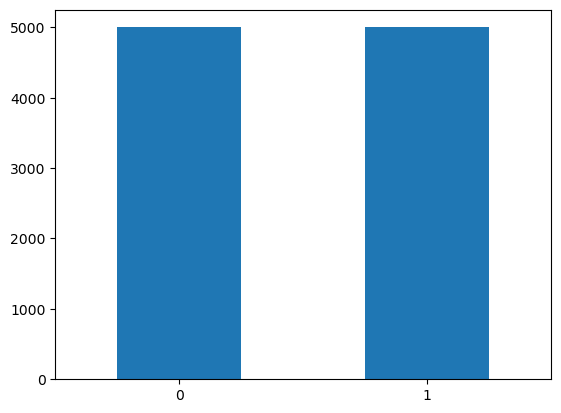

In [28]:
# making sure that the training data are balanced
pd.Series(y_train2).value_counts().sort_index().plot(kind='bar', rot=0);

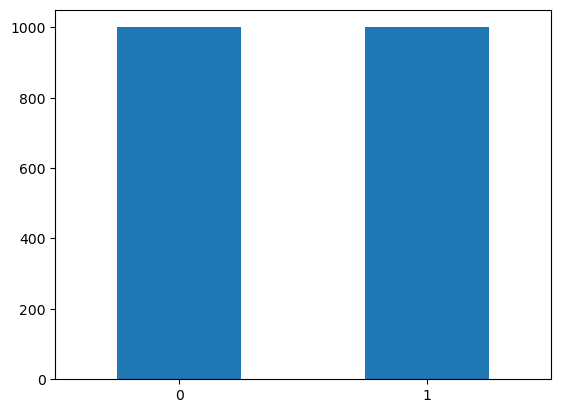

In [29]:
# making sure that the testing data are balanced
pd.Series(y_test2).value_counts().sort_index().plot(kind='bar', rot=0);

## 1.  SVM models

### 1.1 Create functions to help me train, test and evaluate the model

- train_test_model()

This function trains the model and also prints the accuracy 

- evaluate_svm()

This function displays the confusion matrix, the classification report and some miscalssified images





In [95]:

def train_test_svm(model,X_train,X_test,y_train,y_test):
    start_time = time.time()
    
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    end_time=time.time()

    acc = accuracy_score(y_test,y_pred)

    print(f"Total time: {(end_time-start_time):.2f}s | Test accuracy: {round(acc*100,2):.2f}%")

    return round(acc*100,2)



# this function is used to evaluate the SVM model and plot the confusion matrix, the classification report and the misclassified images
def evaluate_svm(model, X_test, y_test, X_test_original): 

    y_pred = model.predict(X_test)

    # Plotting the confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    display(plt.show())

    # Printing the classification report
    report = classification_report(y_test, y_pred, digits=3, target_names=class_names)
    print(report)

    # Identifying misclassified indices
    misclassified_idx = np.where(y_test != y_pred)[0]

    # Plotting misclassified images
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    for i, ax in enumerate(axes.flat): 
        if i >= len(misclassified_idx):
            ax.axis('off')
        else:
            idx = misclassified_idx[i]
            img = X_test_original[idx]

            # Ensure the image has the correct shape
            if img.shape == (3, 32, 32):
                img = img.transpose([1,2,0])
                ax.imshow(img)  # Display original image
            else:
                img = img.reshape(3,32,32)
                img = img.transpose([1,2,0])
                ax.imshow(img)
                

            #ax.set_title(f"Label: {class_names[y_test[idx]]} , Pred: {class_names[y_pred[idx]]}")
            ax.set_title(f"Label: {class_names[y_test[idx]]}, Pred: {class_names[y_pred[idx]]}")
            
            ax.axis('off')

    plt.tight_layout()
    plt.show()







Lets see how time consuming is the default SVM model in the pca reduced dataset

In [17]:
svm_v0 = SVC()
acc = train_test_svm(svm_v0,X_train_pca,X_test_pca,y_train,y_test)


print(f"SVM default accuracy: {acc}")


Total time: 525.28s | Test accuracy: 53.84%
SVM default accuracy: 53.84


### 1.2 SVMs for binary classification

From the above cell i see that the default SVM in the PCA reduced dataset takes roughly 10 minutes. I can't tune the hyperparameters if each model takes this much time. So i will use only the 1st and 2nd class and i will see how well SVMs with different kernels perform

In [33]:
# lets first use the default hyperparameters
svm_v1 = SVC()
acc = train_test_svm(svm_v1,X_train2_sc_pca,X_test2_sc_pca,y_train2,y_test2)



Total time: 14.05s | Test accuracy: 90.60%


In [21]:
# A low C encourages a simpler model with a wider margin but may lead to some misclassifications.
# A high C tries to classify all training points correctly, potentially causing overfitting

# Small coef0: Focuses on higher-degree polynomial terms, capturing more complex relationships in data.
# Large coef0: Gives more importance to lower-degree terms, leading to simpler decision boundaries.

# Small gamma values: A wide influence, resulting in a smoother decision boundary (underfitting risk).
# Large gamma values: A narrow influence, allowing the model to fit more details (overfitting risk).

# Set up RandomizedSearchCV

param_grid={
    "kernel":["poly"],
    "degree":[2,3,4,5], 
    "gamma":[0.001,0.01,0.1,1],
    "C":[0.1,1,10],   #
    "coef0":[0,1,10]
}

random_search_poly = RandomizedSearchCV(SVC(),param_grid,n_iter=40,cv=3,scoring="accuracy",n_jobs=-1,verbose=2, random_state=42)

random_search_poly.fit(X_train2_sc_pca,y_train2)

print(f"\nBest randomSearch poly parameters: {random_search_poly.best_params_}")

best_randomSearch_poly = random_search_poly.best_estimator_

y_pred2_best_randomSearch_poly = best_randomSearch_poly.predict(X_test2_sc_pca) #predicting the test data

best_randomSearch_poly_acc = accuracy_score(y_test2,y_pred2_best_randomSearch_poly) #calculating the accuracy   

print(f"Best randomSearch poly accuracy: {round(best_randomSearch_poly_acc*100,2)}%")





Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best randomSearch poly parameters: {'kernel': 'poly', 'gamma': 0.001, 'degree': 5, 'coef0': 1, 'C': 10}
Best randomSearch poly accuracy: 91.05%


In [22]:
# When to Use the RBF Kernel
# Nonlinear Problems: When the relationship between features and classes is not linear.
# High-Dimensional Data: RBF works well even when the number of features is much larger than the number of samples.


param_grid = {
    "C": [0.1, 1, 10, 100, 200],  # Regularization parameter
    "gamma": [0.001, 0.01, 0.1, 1],  # RBF kernel parameter
    "kernel": ["rbf"],
    'tol': [1e-4, 1e-3, 1e-2]
}

random_search_rbf = RandomizedSearchCV(SVC(), param_grid,n_iter=40,cv=3, scoring="accuracy", verbose=3, n_jobs=-1, random_state=42)

random_search_rbf.fit(X_train2_sc_pca,y_train2)

print(f"\nBest parameters: {random_search_rbf.best_params_}")

best_randomSearch_rbf = random_search_rbf.best_estimator_

y_pred2_best_randomSearch_rbf = best_randomSearch_rbf.predict(X_test2_sc_pca)

best_randomSearch_rbf_acc = accuracy_score(y_test2,y_pred2_best_randomSearch_rbf)

print(f"Best randomSearch rbf accuracy: {round(best_randomSearch_rbf_acc*100,2)}%")


Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best parameters: {'tol': 0.01, 'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
Best randomSearch rbf accuracy: 90.65%


In [24]:
# When to Use the Linear Kernel

# Linearly Separable Data: Works well if the classes can be separated with a straight line or a hyperplane.
# High-Dimensional Data: Performs well in cases where the number of features is very large (e.g., text classification, where features are word counts or embeddings).
# Efficiency: Faster to compute compared to non-linear kernels (like RBF or polynomial), as it avoids complex transformations.
# Low Noise: Best suited for datasets with less noise or overlap between classes.

param_grid = {
    "kernel":["linear"],
    "C": [0.1, 1, 10, 100],
    'tol': [1e-4, 1e-3, 1e-2]
}

random_search_linear = RandomizedSearchCV(SVC(), param_grid, n_iter=12,cv=3, scoring="accuracy", verbose=3, n_jobs=-1, random_state=42)

random_search_linear.fit(X_train2_sc_pca,y_train2)

print(f"\nBest parameters: {random_search_linear.best_params_}")

best_randomSearch_linear = random_search_linear.best_estimator_

y_pred2_best_randomSearch_linear = best_randomSearch_linear.predict(X_test2_sc_pca)

best_randomSearch_linear_acc = accuracy_score(y_test2,y_pred2_best_randomSearch_linear)

print(f"Best randomSearch linear accuracy: {round(best_randomSearch_linear_acc*100,2)}%")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'tol': 0.01, 'kernel': 'linear', 'C': 10}
Best randomSearch linear accuracy: 82.7%


### 1.3 SVMs for multiclass classification

From the above, i think that the kernels that work best for images are the rbf and the poly. So below i will use all the classes and i will try to find the best hyperparameters for a Support Vector Model

In [ ]:
svm_ovo_v1 = SVC(kernel = "rbf",C=10,gamma=0.1)

train_test_svm(svm_ovo_v1,X_train_sc_pca,X_test_sc_pca,y_train,y_test)

#THIS TOOK TOO MUCH TIME

Using all the samples for the training and the testing of the model is too time consuming. So i will create a function that keeps 80% of the most common images and 20% of the outiliers images for each class. I will be able to change the size of the dataset, but also extract important conclusions about which hyperparameters make our model better

In [25]:
import numpy as np
from sklearn.metrics import pairwise as sklearn_pairwise

def reduce_dataset_combined(X, y, num_samples_per_class):
    """
    Reduces the dataset by selecting a mix of representative and diverse samples.
    
    Args:
        X: Feature matrix (num_samples, num_features).
        y: Labels (num_samples,).
        num_samples_per_class: Desired number of samples per class.

    Returns:
        X_reduced, y_reduced: Reduced feature matrix and labels, shuffled.
    """
    X = np.array(X)
    y = np.array(y)
    unique_classes = np.unique(y)
    X_reduced, y_reduced = [], []
    rep_ratio = 0.8  # 80% representative, 20% diverse

    for cls in unique_classes:
        # Get samples belonging to this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        
        # Compute the average sample for the class
        avg_sample = np.mean(X_cls, axis=0, keepdims=True)
        
        # Compute distances of all samples to the average sample
        distances = sklearn_pairwise.euclidean_distances(X_cls, avg_sample).flatten()
        
        # Split indices into representative and diverse
        num_representative = int(rep_ratio * num_samples_per_class)
        num_diverse = num_samples_per_class - num_representative

        representative_indices = np.argsort(distances)[:num_representative]
        diverse_indices = np.argsort(distances)[-num_diverse:]
        
        # Combine selected samples
        selected_indices = np.concatenate((representative_indices, diverse_indices))
        
        X_reduced.append(X_cls[selected_indices])
        y_reduced.append(y_cls[selected_indices])
    
    # Combine all reduced samples
    X_reduced = np.vstack(X_reduced)
    y_reduced = np.hstack(y_reduced)
    
    # Shuffle the combined data while keeping the pairs intact
    indices = np.random.permutation(X_reduced.shape[0])
    X_reduced = X_reduced[indices]
    y_reduced = y_reduced[indices]
    
    return X_reduced, y_reduced


In [ ]:
#Reducing the size of the training data to 2500 samples for each class
X_train_reduced,y_train_reduced = reduce_dataset_combined(X_train_sc_pca,y_train,2500)

X_train_reduced.shape, y_train_reduced.shape

((25000, 131), (25000,))

In [11]:
#train and test the default SVM to see what accuracy we get
train_test_svm(SVC(),X_train_reduced,X_test_sc_pca,y_train_reduced,y_test)

Total time: 359.53s | Test Balanced accuracy: 50.76%


50.76

Finding the best combination of hyperparameters for my SVM is too time consuming. Thats why i am using the RandomizedSearchCV. This way i use many sets of hyperparameters and i get the combination that gives the best accuracy. I chose the RandomizedSearchCV rather than the GridSearchCV because the GridSearchCV uses all the combinations of the given hyperparameters, but this makes it too time consuming. On the other hand RandomizedSearchCV doesnt try all the combinations, making it faster .

- RandomizedSearchCV for the rbf kernel

In [ ]:
# Define the parameter distribution
param_dist = {
        'kernel': ['rbf'],
        'C': [ 0.1, 1, 10, 100],
        'gamma': [1e-3, 0.01, 0.1, 1],
        'shrinking': [True, False],
        'tol': [1e-4, 1e-3, 1e-2]
}

# Initialize the SVM
svm = SVC()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=75,  # Number of different combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1,  # Use all available cores
    verbose=3,
    random_state=42  # Reproducibility
)

# Fit the model
random_search.fit(X_train_reduced, y_train_reduced)

# Print the best parameters and score
print(f"Best randomSearch rbf parameters: {random_search.best_params_}")
 
# To use the best estimator
best_randomSearch_rbf10 = random_search.best_estimator_


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best randomSearch rbf parameters: {'tol': 0.001, 'shrinking': True, 'kernel': 'rbf', 'gamma': 0.01, 'C': 10}


In [39]:
y_pred_best_randomSearch_rbf10 = best_randomSearch_rbf10.predict(X_test_sc_pca)
best_randomSearch_rbf10_acc = accuracy_score(y_test,y_pred_best_randomSearch_rbf10)
print(f"best randomSearch accuracy: {round(best_randomSearch_rbf10_acc*100,2)}%")

best randomSearch balanced accuracy: 51.47%


- RandomizedSearchCV for the poly kernel

In [40]:
param_dist = {
        'kernel': ['poly'],
        'C': [ 0.1, 1, 10, 100],
        'gamma': [1e-3, 0.01, 0.1, 1],
        'degree': [2, 3, 4, 5],
        'coef0': [0.0, 0.1, 0.5, 1.0],
        'shrinking': [True, False],
        'tol': [1e-4, 1e-3, 1e-2]     
}
    
       



# Initialize RandomizedSearchCV with conditional parameter grid
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=75,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    random_state=42 # Reproducibility
)

# Fit the model
random_search.fit(X_train_reduced, y_train_reduced)

# Print the best parameters and score
print(f"Best randomSearch poly parameters: {random_search.best_params_}")

# To use the best estimator
best_randomSearch_poly10 = random_search.best_estimator_


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best randomSearch poly parameters: {'tol': 0.01, 'shrinking': True, 'kernel': 'poly', 'gamma': 0.01, 'degree': 3, 'coef0': 1.0, 'C': 1}


In [41]:
y_pred_best_randomSearch_poly10 = best_randomSearch_poly10.predict(X_test_sc_pca)
best_randomSearch_poly10_acc = balanced_accuracy_score(y_test,y_pred_best_randomSearch_poly10)
print(f"best random search poly accuracy: {round(best_randomSearch_poly10_acc*100,2)}%")

best random search poly accuracy: 51.87%


In [42]:
best_svm = best_randomSearch_poly10 if best_randomSearch_poly10_acc > best_randomSearch_rbf10_acc else best_randomSearch_rbf10
best_svm

SVC(C=1, coef0=1.0, gamma=0.01, kernel='poly', tol=0.01)

In [96]:
#Now use the whole dataset for the best model that i got from the RandomizedSearchCV
train_test_svm(best_svm,X_train_sc_pca,X_test_sc_pca,y_train,y_test)

Total time: 534.85s | Test accuracy: 55.30%


55.3

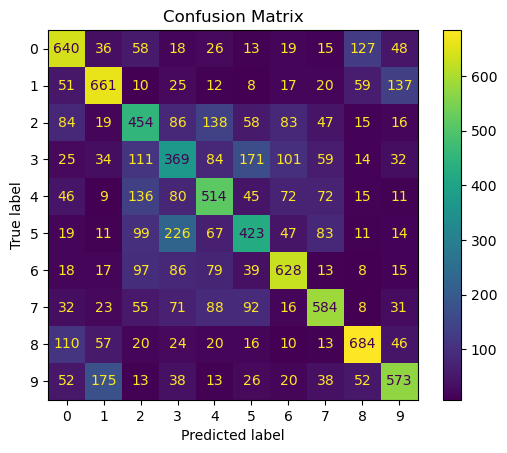

None

              precision    recall  f1-score   support

    airplane      0.594     0.640     0.616      1000
  automobile      0.634     0.661     0.647      1000
        bird      0.431     0.454     0.442      1000
         cat      0.361     0.369     0.365      1000
        deer      0.494     0.514     0.504      1000
         dog      0.475     0.423     0.447      1000
        frog      0.620     0.628     0.624      1000
       horse      0.619     0.584     0.601      1000
        ship      0.689     0.684     0.686      1000
       truck      0.621     0.573     0.596      1000

    accuracy                          0.553     10000
   macro avg      0.554     0.553     0.553     10000
weighted avg      0.554     0.553     0.553     10000



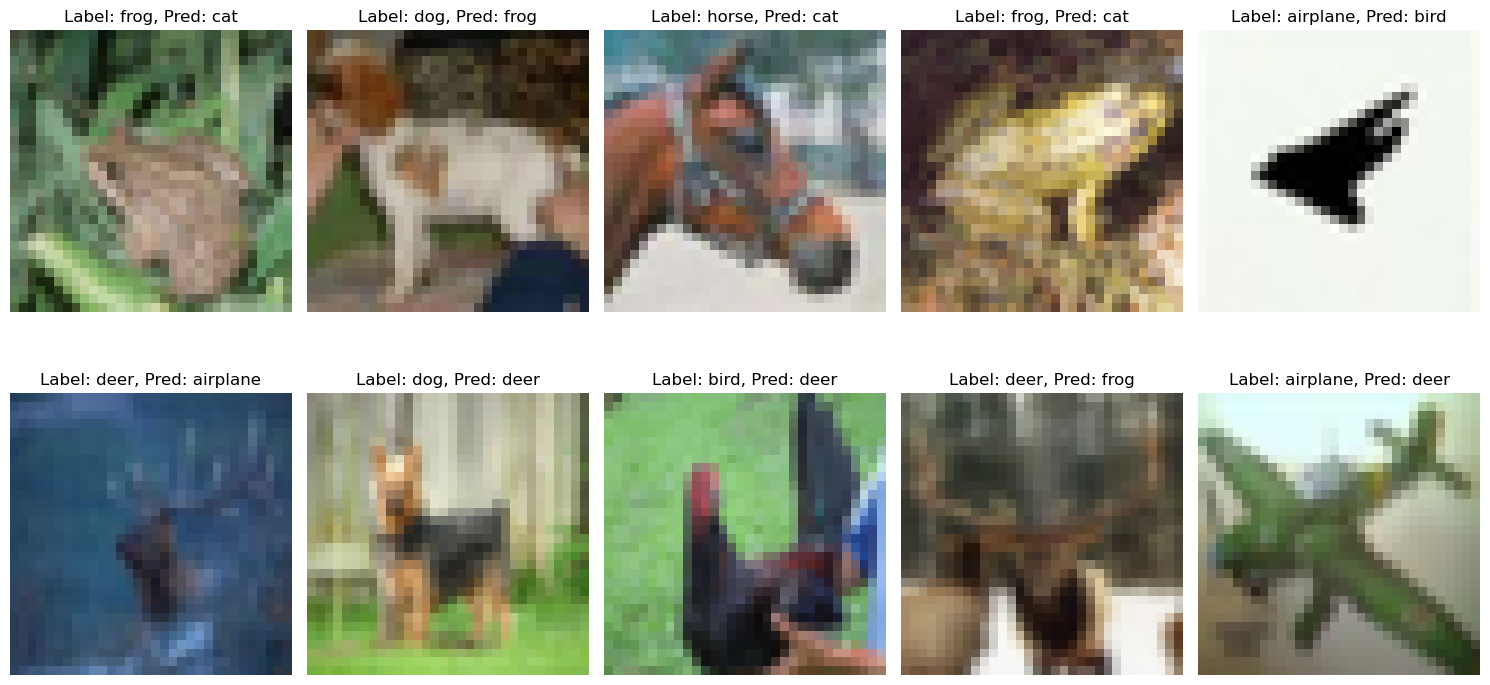

In [97]:
evaluate_svm(best_svm,X_test_sc_pca,y_test,X_test)

### 1.4 Bagging

Bagging is an ensemble learning technique aimed at improving the performance and robustness of machine learning models. 

This technique creates multiple subsets of the training dataset by randomly sampling with replacement. This way some samples might be picked multible times, when others might not be picked, making each subset slightly different due to randomness.

The svm with the best combination of hyperparameters from the above cells is trained on each bootstrap subset.

Using majority voting the bagging model determines the final prediction

In [98]:
bagging_model = BaggingClassifier(
    estimator = best_svm,
    n_estimators = 100,   #this way i will train 100 base models (best_svm)
    random_state = 42,
    n_jobs = -1
)

#use the whole dataset for the bagging model
acc = train_test_svm(bagging_model,X_train_sc_pca,X_test_sc_pca,y_train,y_test)





Total time: 7543.61s | Test accuracy: 56.17%


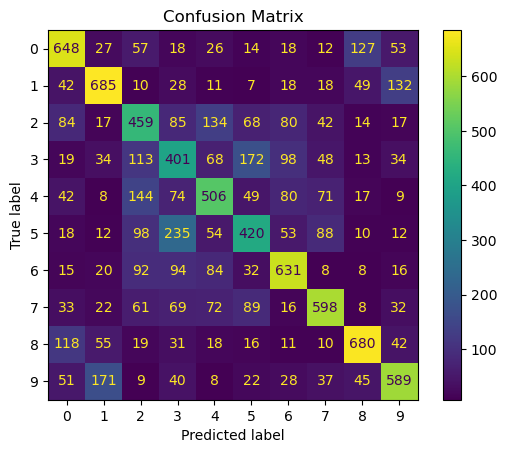

None

              precision    recall  f1-score   support

    airplane      0.606     0.648     0.626      1000
  automobile      0.652     0.685     0.668      1000
        bird      0.432     0.459     0.445      1000
         cat      0.373     0.401     0.387      1000
        deer      0.516     0.506     0.511      1000
         dog      0.472     0.420     0.445      1000
        frog      0.611     0.631     0.621      1000
       horse      0.642     0.598     0.619      1000
        ship      0.700     0.680     0.690      1000
       truck      0.629     0.589     0.608      1000

    accuracy                          0.562     10000
   macro avg      0.563     0.562     0.562     10000
weighted avg      0.563     0.562     0.562     10000



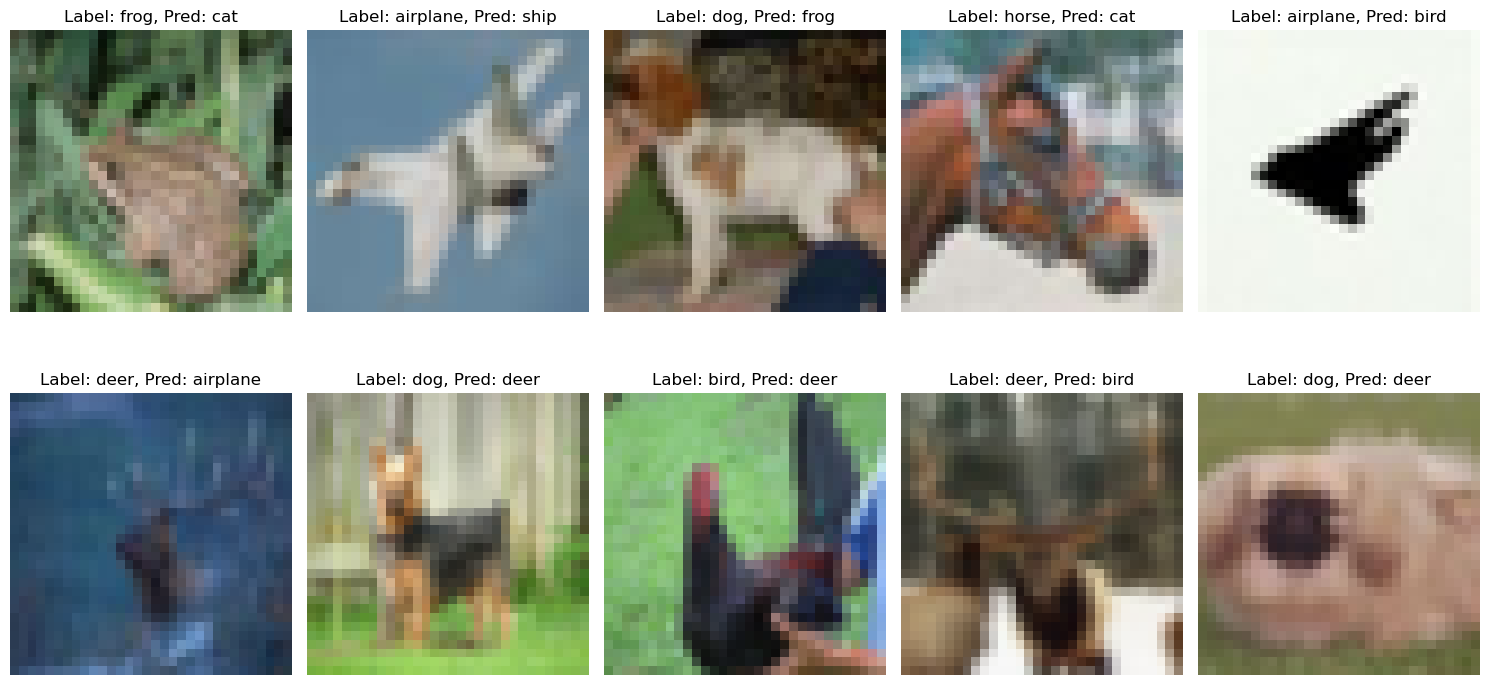

In [99]:
evaluate_svm(bagging_model,X_test_sc_pca,y_test,X_test)

# Load the best CNN

# Create KNN